In [2]:
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/data'

In [4]:
#find bounding box position from xml file
tree = ET.parse('/content/drive/MyDrive/data/cucumber_1.xml')
root = tree.getroot()
path_bounding_box = './object/bndbox/'

xmin = int(root.find(path_bounding_box + 'xmin').text)
ymin = int(root.find(path_bounding_box + 'ymin').text)
xmax = int(root.find(path_bounding_box + 'xmax').text)
ymax = int(root.find(path_bounding_box + 'ymax').text)


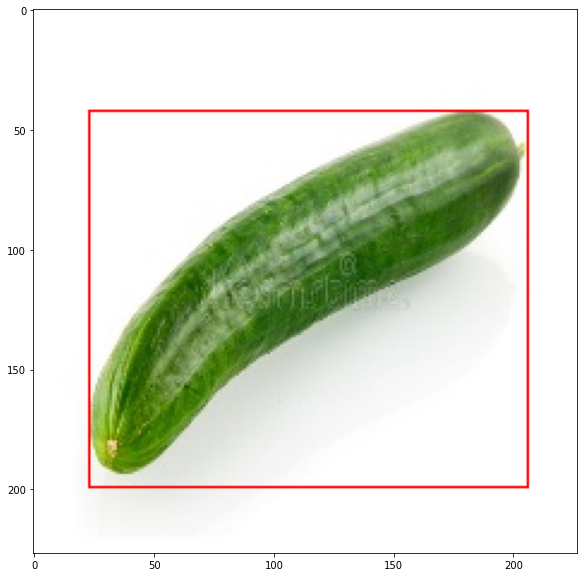

In [5]:
#show sample object localization
image = cv.imread('/content/drive/MyDrive/data/cucumber_1.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
plt.figure(figsize=(13,10))

plt.imshow(image)


plt.show()

In [6]:
# create list of label and xmin, ymin, xmax, ymax

files = os.listdir(base_dir)
xml_files = []
outputs = []
image_files = []
for file in (files):
    if file.endswith('.xml'):
        tree = ET.parse(os.path.join(base_dir, file))
        root = tree.getroot()
        path_bounding_box = './object/bndbox/'
        
        label_text = root.find('./object/name').text
        if label_text == 'cucumber':
            label = 0
        elif label_text == 'eggplant':
            label = 1
        else:
            label = 2
        
        xmin = int(root.find(path_bounding_box + 'xmin').text)
        ymin = int(root.find(path_bounding_box + 'ymin').text)
        xmax = int(root.find(path_bounding_box + 'xmax').text)
        ymax = int(root.find(path_bounding_box + 'ymax').text)

        xml_files.append(file)
        outputs.append([label, xmin, ymin, xmax, ymax])
        # labels.append(label)
    else:
        image = cv.imread(os.path.join(base_dir, file))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, (224,224))
        image_files.append(image)

In [7]:
inputs = np.array(image_files)
outputs = np.array(outputs)

In [8]:
#train test split

x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size = 0.3, random_state = 42)

In [9]:
print('x train shape: {}'.format(x_train.shape))
print('x test shape: {}'.format(x_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

x train shape: (130, 224, 224, 3)
x test shape: (56, 224, 224, 3)
y train shape: (130, 5)
y test shape: (56, 5)


In [10]:
#seperate labels and bounding box values
label_train = y_train[:,0]
label_test = y_test[:,0]
bounding_box_train = y_train[:,1:5]
bounding_box_test = y_test[:,1:5]

In [11]:
print('labels train shape: {}'.format(label_train.shape))
print('labels test shape: {}'.format(label_test.shape))
print('bounding boxes train shape: {}'.format(bounding_box_train.shape))
print('bounding boxes test shape: {}'.format(bounding_box_test.shape))

labels train shape: (130,)
labels test shape: (56,)
bounding boxes train shape: (130, 4)
bounding boxes test shape: (56, 4)


In [12]:
# hot encode labels
label_train = tf.keras.utils.to_categorical(label_train, num_classes = 3)
label_test = tf.keras.utils.to_categorical(label_test, num_classes = 3)

In [13]:
# Model
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    classes = 3,
    weights = 'imagenet',
    include_top= False
)

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
# inputs = tf.keras.Input(shape = (224, 224, 3))
# x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
# x = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu')(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

In [15]:
base_model = tf.keras.layers.Flatten()(mobilenet.output)
x = tf.keras.layers.Dropout(0.5)(base_model)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x1 = tf.keras.layers.Dense(3, activation='softmax', name = 'classification')(x) # output for class
x2 = tf.keras.layers.Dense(4, activation = 'relu', name = 'bounding_box')(x) # output for bounding box

model = tf.keras.Model(inputs = [mobilenet.input], outputs = [x1, x2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [16]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-4),
    loss = {'classification':'categorical_crossentropy',
            'bounding_box': 'mse'},
    metrics = {'classification': ['accuracy'],
                'bounding_box': ['mse']}
)

history = model.fit(
    x_train, 
    [label_train, bounding_box_train],
    epochs = 50,
    validation_data= (x_test, [label_test, bounding_box_test]),
    verbose = 1,
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
5/5 [==============================] - 16s 616ms/step - loss: 17344.8379 - classification_loss: 2.1074 - bounding_box_loss: 17342.7305 - classification_accuracy: 0.3615 - bounding_box_mse: 17342.7305 - val_loss: 13301.2314 - val_classification_loss: 6.2327 - val_bounding_box_loss: 13294.9980 - val_classification_accuracy: 0.3036 - val_bounding_box_mse: 13294.9980
Epoch 2/50
5/5 [==============================] - 1s 184ms/step - loss: 9443.9141 - classification_loss: 9.6268 - bounding_box_loss: 9434.2881 - classification_accuracy: 0.3385 - bounding_box_mse: 9434.2881 - val_loss: 6923.1226 - val_classification_loss: 13.6083 - val_bounding_box_loss: 6909.5146 - val_classification_accuracy: 0.3036 - val_bounding_box_mse: 6909.5146
Epoch 3/50
5/5 [==============================] - 1s 192ms/step - loss: 2615.2280 - classification_loss: 20.3871 - bounding_box_loss: 2594.8413 - classification_accuracy: 0.3385 - bounding_box_mse: 2594.8413 - val_loss: 3120.9648 - val_classification_l

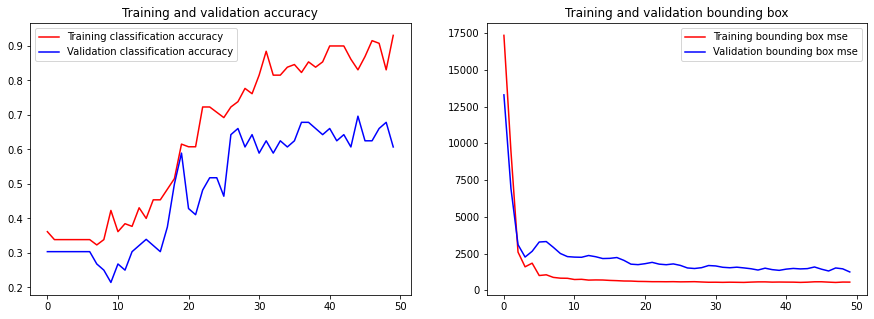

In [17]:
train_classification_acc = history.history['classification_accuracy']
val_classification_acc = history.history['val_classification_accuracy']

bounding_box_mse = history.history['bounding_box_mse']
val_bounding_box_mse = history.history['val_bounding_box_mse']

epochs = range(len(train_classification_acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, train_classification_acc, 'r', label='Training classification accuracy')
ax1.plot(epochs, val_classification_acc, 'b', label='Validation classification accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, bounding_box_mse, 'r', label='Training bounding box mse')
ax2.plot(epochs, val_bounding_box_mse, 'b', label='Validation bounding box mse')
ax2.set_title('Training and validation bounding box')
ax2.legend(loc=0)

plt.show()



In [39]:
model.save('/content/drive/MyDrive/object_localization.h5')

In [5]:
model = tf.keras.models.load_model('/content/drive/MyDrive/object_localization.h5')

1/1 [==============================] - 0s 52ms/step


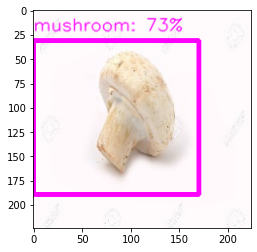

In [11]:
image = cv.imread('/content/drive/MyDrive/data/mushroom_9.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (224,224))

label, bounding_box = model.predict(np.expand_dims(image, axis=0))

confidence_value = label[0][np.argmax(label)]

label_pred = np.argmax(label)

if label_pred == 0:
  label = 'cucumber'
elif label_pred == 1:
  label = 'eggplant'
else:
  label = 'mushroom'

text = '{}: {percent:.0%}'.format(label, percent=confidence_value)
cv.rectangle(image, (int(bounding_box[0][0]), int(bounding_box[0][1])), (int(bounding_box[0][2]), int(bounding_box[0][3])), (255, 0, 255), 3)
cv.putText(image, text, (int(bounding_box[0][0]), int(bounding_box[0][1]-10)), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,255), 1, 255)
plt.imshow(image)
plt.show()